# Executive Summary

Following the implementation of numerous safety protocols, play in the NFL has resumed. Betting lines and spreads have been created to predict outcomes in the season game by game. The desired outcome of this project was modeling of NFL game spreads, prediction of which teams will win, and prediction of which teams will beat the spread. Beating the spread is not an easy feat, as the betting spread is set and fluctuates based on the betting patterns of professionals who have spent years predicting NFL games. Thus, the goal accuracy of the model predicting which teams would beat the spread was modest at 55%. The accuracy in predicting wins was likely higher, as wins are more consistent based on favorites.

The data used for analysis was extracted using the **sportsreference** package. This package provided team stats and schedules by team and year. The data for historical spreads was provided by a Kaggle dataset (Tobycrabtree, 2020), which contained the data, opponents, and spread of the games.

The first model created was the model predicting spread. Numerous models were evaluated, and a lasso regression model was selected through cross validation. The root mean squared error of this model on the test set was 11.3 points, which is somewhat high given the low point differentials that typify most NFL games. 

The second model focused on predicting which team in each match up will win. The selected model was a voting classifier that incorporated both a logistic regression model and a linear SVM model, averaged using soft voting. This model performed fairly well on the test set, with 75% accuracy. This accuracy is fairly high and is overall a good result.

The last model predicted which team will beat the spread. A linear SVM model was selected for this task, which performed fairly well on the test set. This model had an accuracy of 64% on the test set. This accuracy is fairly high and meets the desired accuracy for prediction. 

One limitation of this model is that the predictions are based on year-end statistics. The current statistics for a team may not be representative of the year-end statistics, but the statistics should be more representative as the season progresses. The results from the model will be provided throughout the 2020 season and are provided in a link on the Readme file.

# Introduction

COVID-19 has affected the US and the world in countless ways, and has completely disrupted the way of life for many. To see visualizations of how COVID-19 has impacted the US according to a number of metrics, see the site for one of my other projects here: [COVID-19 Visualizations](https://www.afbcovid19viz.com). A byproduct of this virus, albeit far less fundamentally important than the numerous other impacts, is the temporary pause on professional and college athletic programs. By taking numerous precautions, however, professional sports have once again resumed play. The precautions taken have varied widely by team and league. 

One such league has been the NFL, which, as of September 24, 2020, is about to enter its third week of play. The restrictions, as mentioned, have varied widely by team. However, play has resumed, and betting lines on the season have started. The spread has been notoriously difficult to beat, as the line is set and affected by bets made by professional bookmakers and gamblers who often have many years experience betting on the NFL. This project was created to meet the challenge of consistently beating the spread, predicting spread, and predicting wins. To accomplish this feat, three models were created, one for each task. 

Any consistent advantage on the spread is considered potentially successful, and beating the spread by a wide margin is considered extremely difficult. Given this challenge, the aim of the model predicting whether a team will beat the spread is 55% accuracy and above. A higher accuracy is expected for the model predicting wins, as favorites are more likely than not to beat the opposing team. This notebook's methodology is divided into four sections, one section for each model and one section on prediction of new games.

# Methodology

## NFL Spread Prediction

First, a model predicting home spreads was created. The data for the model was extracted from the **sportsreference** package. Several attributes were selected for inclusion in the analysis. These attributes are shown below, divided into two groups, one containing attributes averaged by game and one containing attributes given on a season basis.

After the attributes were selected, a loop was created to create the dataframe containing these attributes. Two preliminary dataframes were first created: one containing season team stats and one containing the team schedules.

The home spreads by game were then determined based on the dataframe containing the team schedules. Duplicate games were dropped. 

The stats for each team in the group of attributes available by season were then standardized by number of games played. The chosen categories were then extracted from the dataframe with team stats.

Finally, the schedule dataframe was merged with the team stats dataframe on away and home team abbreviations. This process was repeated for all years in the desired range.

In [1]:
from sportsreference.nfl.teams import Teams
import pandas as pd
from sportsreference.nfl.schedule import Schedule

year1 = 2010
year2 = 2019

stats_per_col = ["margin_of_victory",
                 "percent_drives_with_points", "percent_drives_with_turnovers", "pass_net_yards_per_attempt",
                 "rush_yards_per_attempt", "strength_of_schedule", "win_percentage",
                 "yards_per_play"]
stats_total = ["first_downs", "first_downs_from_penalties", "fumbles", "interceptions", 
                  "pass_attempts", "pass_completions", "pass_first_downs", "pass_touchdowns",
                  "pass_yards", "penalties", "plays", "points_contributed_by_offense",
                  "points_difference", "rush_attempts", "rush_first_downs", "rush_touchdowns", 
                  "rush_yards", "turnovers", "yards", "yards_from_penalties"]

all_year_df = pd.DataFrame()

for year in range(year1, year2 + 1):
    stats_df = pd.DataFrame()
    games_df = pd.DataFrame()
    teams = Teams(year)
    for team in teams:
        stats_df = pd.concat([stats_df, team.dataframe], axis=0)
        team_abbrev = team.abbreviation
        team_sched = Schedule(abbreviation=team_abbrev, year=year)
        team_sched_df = team_sched.dataframe
        team_sched_df["team"] = team_abbrev
        games_df = pd.concat([games_df, team_sched_df], axis=0)

    games_df = games_df[["team", "opponent_abbr", "location", "points_allowed", 
                         "points_scored", "datetime"]].copy()
    games_df["home"] = games_df.apply(lambda x: x[1] if x[2] == "Away" else x[0], axis=1)
    games_df["away"] = games_df.apply(lambda x: x[0] if x[2] == "Away" else x[1], axis=1)
    games_df["home_spread"] = games_df.apply(lambda x: x[3] - x[4] if x[2] == "Home" 
                                             else x[4] - x[3], axis=1)
    games_df = games_df[["home", "away", "home_spread", "datetime"]].copy()
    games_df.drop_duplicates(inplace=True)
    games_df = games_df.reset_index().drop("index", axis=1)

    stats_df[stats_total] = stats_df[stats_total].div(stats_df["games_played"], axis=0)

    chosen_col = stats_per_col + stats_total + ["abbreviation"]
    stats_df = stats_df[chosen_col]

    home_df = pd.merge(games_df, stats_df, left_on="home", right_on="abbreviation")
    full_df = pd.merge(home_df, stats_df, left_on="away", right_on="abbreviation", 
                       suffixes=("_home", "_away"))
    full_df.drop(["home", "away", "datetime", "abbreviation_home", "abbreviation_away"], 
                 axis=1, inplace=True)

    all_year_df = pd.concat([all_year_df, full_df], axis=0)

The **warnings** package was imported to silence warnings.

In [2]:
import warnings

warnings.filterwarnings('ignore')

Next, the describe method was run on the dataframe to get a better understanding of the data. All columns have the same length, indicating that there are no null values. Additionally, the features vary widely in their means and quartiles, indicating that the data must be scaled.

In [3]:
all_year_df.describe()

,home_spread,margin_of_victory_home,percent_drives_with_points_home,percent_drives_with_turnovers_home,pass_net_yards_per_attempt_home,rush_yards_per_attempt_home,strength_of_schedule_home,win_percentage_home,yards_per_play_home,first_downs_home,...,plays_away,points_contributed_by_offense_away,points_difference_away,rush_attempts_away,rush_first_downs_away,rush_touchdowns_away,rush_yards_away,turnovers_away,yards_away,yards_from_penalties_away
count,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,...,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.000000,2680.00000
mean,-2.256716,0.327873,34.744590,11.967948,6.317500,4.210410,-0.015224,0.510785,5.437612,19.923881,...,63.832463,-0.818029,0.232369,26.744543,5.990275,0.799090,113.036217,1.473507,347.157439,55.56236
std,14.617091,6.342051,6.633268,3.225617,0.739886,0.436536,1.629645,0.194826,0.483999,2.277658,...,2.982821,6.700238,6.238585,3.090338,1.213206,0.288669,20.492200,0.406162,36.786709,8.64528
min,-58.000000,-13.400000,18.900000,4.100000,4.200000,3.100000,-4.200000,0.000000,4.100000,14.062500,...,54.875000,-18.565000,-13.375000,20.000000,3.500000,0.187500,72.250000,0.500000,241.562500,25.93750
25%,-10.000000,-4.500000,30.200000,9.600000,5.800000,3.900000,-1.200000,0.375000,5.100000,18.421875,...,62.062500,-5.622656,-4.500000,24.625000,5.125000,0.562500,98.125000,1.187500,319.875000,50.06250
50%,-3.000000,0.400000,34.700000,11.600000,6.200000,4.200000,0.000000,0.500000,5.400000,19.812500,...,63.625000,-1.398125,0.437500,26.375000,5.875000,0.812500,110.562500,1.437500,346.375000,55.28125
75%,7.000000,5.200000,39.000000,14.400000,6.900000,4.500000,1.200000,0.688000,5.800000,21.375000,...,65.812500,3.784375,4.812500,28.687500,6.750000,1.000000,125.062500,1.750000,372.500000,60.31250
max,49.000000,15.600000,52.600000,21.000000,8.300000,5.500000,4.300000,0.938000,6.800000,27.750000,...,74.437500,18.633750,15.562500,37.250000,11.750000,1.812500,206.000000,2.750000,467.125000,84.87500


The target variable, home spread, was extracted and the data was separated train and test sets. The test set was re-created into a dataframe to visualize the variables.

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)

all_year_df.dropna(inplace=True, axis=0)
nfl_labels = all_year_df.columns

X = all_year_df.drop("home_spread", axis=1)
y = all_year_df["home_spread"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

nfl_train = pd.DataFrame(np.c_[y_train, X_train], columns=nfl_labels)
nfl_train.head()

,home_spread,margin_of_victory_home,percent_drives_with_points_home,percent_drives_with_turnovers_home,pass_net_yards_per_attempt_home,rush_yards_per_attempt_home,strength_of_schedule_home,win_percentage_home,yards_per_play_home,first_downs_home,...,plays_away,points_contributed_by_offense_away,points_difference_away,rush_attempts_away,rush_first_downs_away,rush_touchdowns_away,rush_yards_away,turnovers_away,yards_away,yards_from_penalties_away
0,-8.0,2.4,34.5,11.8,5.9,4.9,-2.3,0.500,5.5,19.1250,...,64.9375,1.716875,7.4375,28.5625,5.8750,1.1250,113.1250,1.8125,395.5625,42.3125
1,-7.0,5.8,36.5,8.9,5.1,4.0,-2.4,0.563,4.6,19.4375,...,62.1250,-11.860625,-8.8125,28.1875,5.8750,0.6875,103.8125,0.9375,284.5625,48.6875
2,10.0,-8.3,26.7,17.2,5.7,3.9,-1.5,0.125,5.0,16.4375,...,64.6875,3.846875,-2.2500,23.2500,4.6875,0.6875,93.6250,1.4375,378.1875,52.5000
3,3.0,2.3,30.3,11.6,6.0,3.6,1.8,0.563,5.1,18.1250,...,61.8750,-1.440000,4.8750,25.7500,5.3750,0.9375,109.2500,1.0625,343.0000,53.0000
4,1.0,6.2,42.4,10.0,7.5,4.7,-0.2,0.750,6.3,21.1250,...,63.4375,1.514375,-1.2500,24.5625,6.6875,1.1250,119.1875,1.3125,350.1250,61.5625


Next, the variables most correlated with home spread were determined. This was accomplished using the corr method and then isolating the variables with the highest positive and negative correlations.

In [5]:
nfl_corr = nfl_train.corr()["home_spread"].sort_values(ascending=False)
highest_pos_corr = nfl_corr[1:11].index.tolist()
highest_neg_corr = nfl_corr[-10:].index.tolist()

Next, a histogram plot was created to describe the distributions of the most positively correlated variables. As shown in the plot, the variables are fairly normally distributed, indicating that they should normalize well with a scaling function.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde871de10>,
      dtype=object)

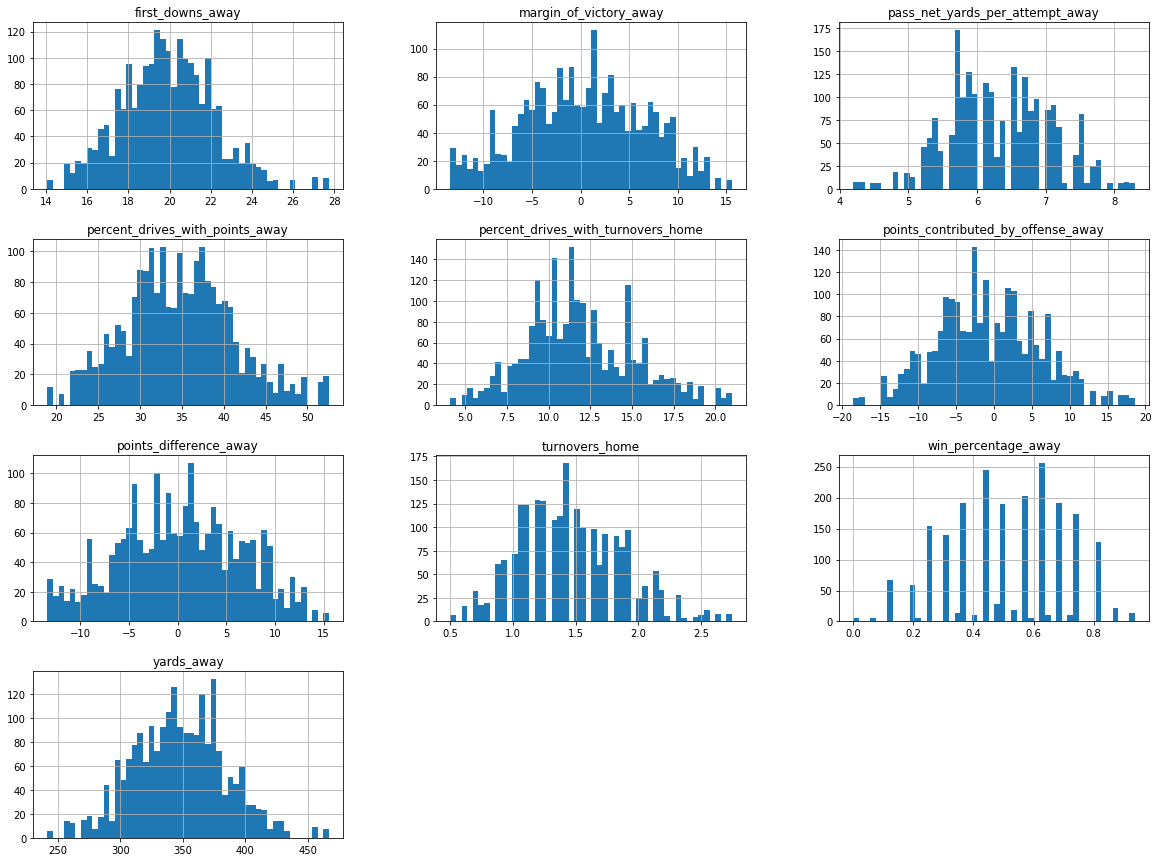

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

nfl_train[highest_pos_corr].hist(bins=50, figsize=(20,15))

The same normal distributions are evident for the variables that are most negatively correlated.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde8f3c310>,
      dtype=object)

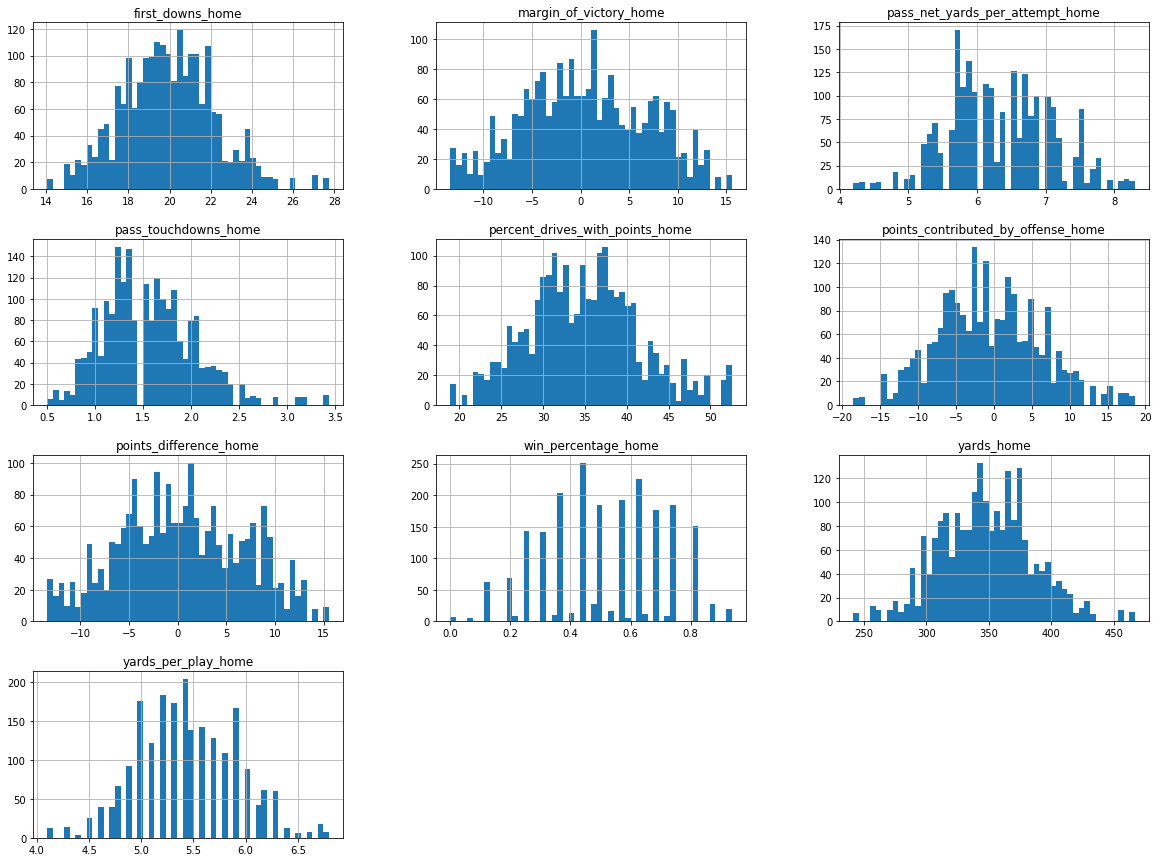

In [7]:
nfl_train[highest_neg_corr].hist(bins=50, figsize=(20,15))

A scatter matrix was created for the variables with highest positive correlation to examine the visual relationship between these variables and home spread. As shown in in the scatter matrix, many of the other variables are strongly related to each other; however, the relationship to home spread is less clear. There appears to be the strongest relationship between the average point difference of the away team and home spread.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde92a1b50>,
      dtype=object)

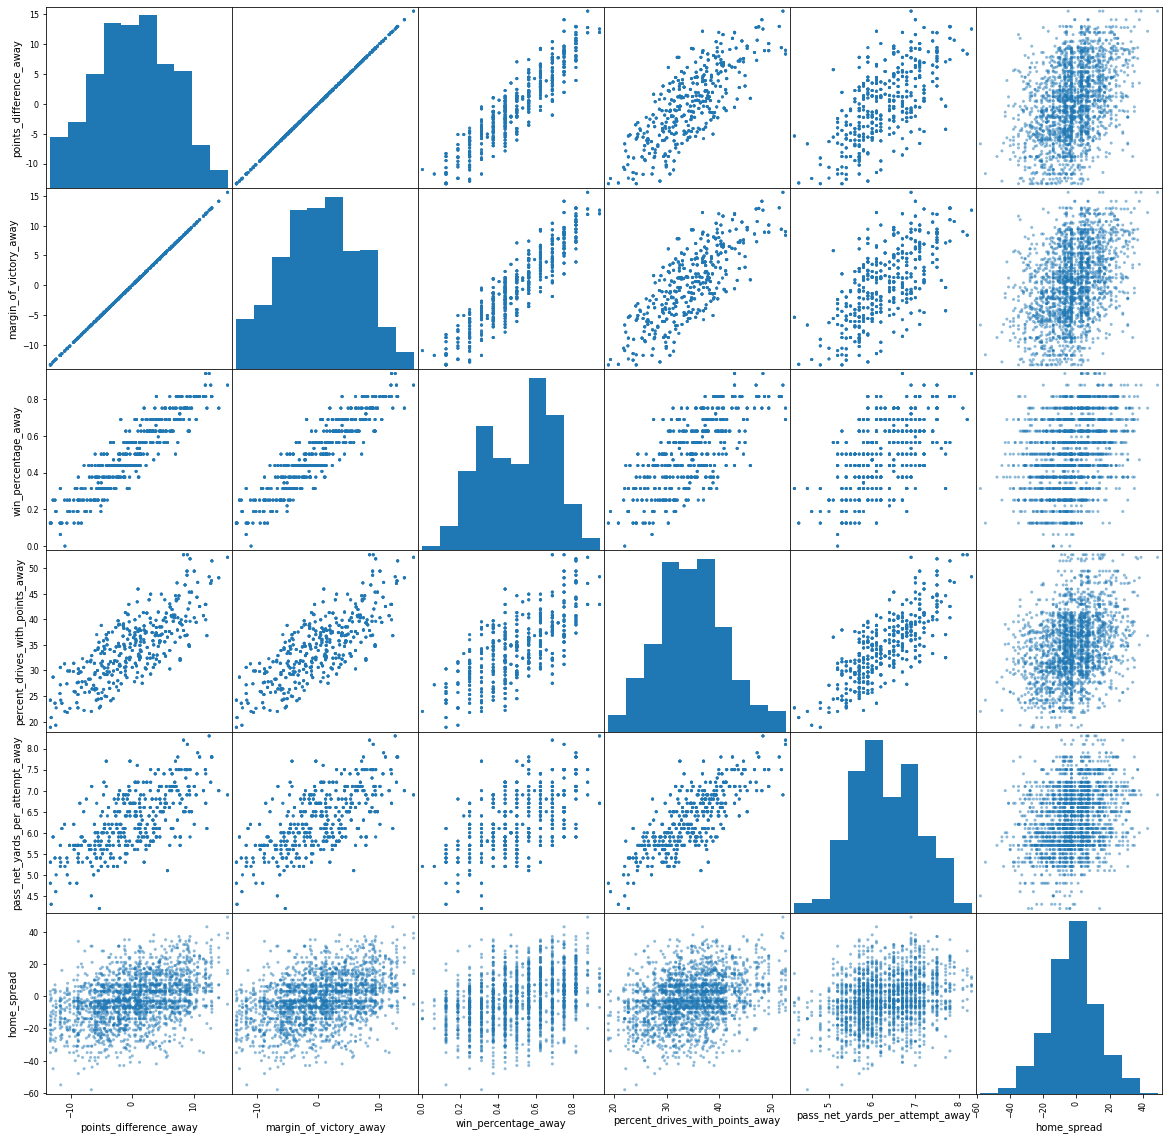

In [8]:
from pandas.plotting import scatter_matrix

nfl_pos_attr = highest_pos_corr[:5] + ["home_spread"]
scatter_matrix(nfl_train[nfl_pos_attr], figsize=(20,20))

The same is true for variables with the strongest negative correlations. The variables appear to be more correlated to themselves than to the home spread.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde8f30f10>,
      dtype=object)

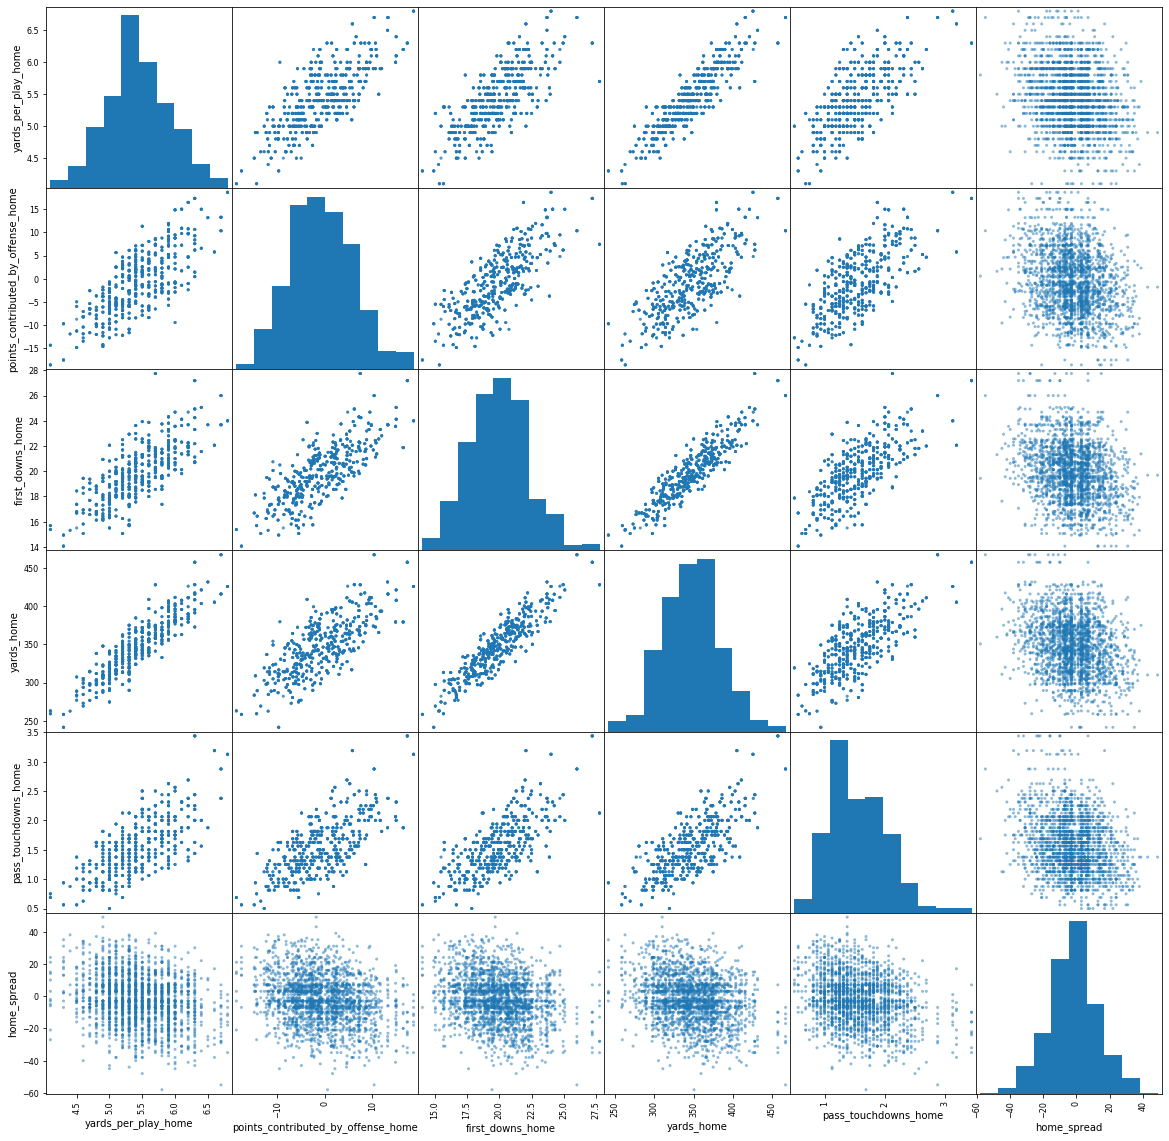

In [9]:
nfl_neg_attr = highest_neg_corr[:5] + ["home_spread"]
scatter_matrix(nfl_train[nfl_neg_attr], figsize=(20,20))

A custom class was then created to add a few attributes based on others. These included pass completion percentage, percentage of first downs that were passing, and percentage of first downs that were rushing.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddedFeatures(BaseEstimator, TransformerMixin):
    """Add relevent features to NFL stats dataframe"""
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy["pass_comp_perc_home"] = X_copy["pass_completions_home"] / X_copy["pass_attempts_home"]
        X_copy["pass_comp_perc_away"] = X_copy["pass_completions_away"] / X_copy["pass_attempts_away"]
        X_copy["first_downs_pass_perc_home"] = X_copy["pass_first_downs_home"] / X_copy["first_downs_home"]
        X_copy["first_downs_pass_perc_away"] = X_copy["pass_first_downs_away"] / X_copy["first_downs_away"]
        X_copy["first_downs_rush_perc_home"] = X_copy["rush_first_downs_home"] / X_copy["first_downs_home"]
        X_copy["first_downs_rush_perc_away"] = X_copy["rush_first_downs_away"] / X_copy["first_downs_away"]
        return X_copy

A pipeline was created for data processing that adds the additional features, imputes the median values for each column to fill null values, and a standard scaler to scale the features. This pipeline was then fitted and used to transform the training data.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

nfl_pipe = Pipeline([
    ("add_feat", AddedFeatures()),
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

nfl_pipe.fit(X_train)
X_train_prepared = nfl_pipe.transform(X_train)

The first model that was used to fit the data is the simplest: linear regression. Cross validation scores were computed to evaluate the model's quality. The model was evaluated with five folds using the negative mean squared error metric. The model was also fitted to the training data. The average root mean squared error (RMSE) was computed based on the cross validation scores.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

np.random.seed(42)

lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train_prepared, y_train, cv=5, scoring="neg_mean_squared_error")
lin_reg.fit(X_train_prepared, y_train)
mean_rmse = (np.mean(-scores) ** 0.5)
mean_rmse

12.297808183894055

The next model used was the ridge model. This model serves to regularize the model parameters and keep the weights small. Given that there is a hyperparameter, alpha, that can be adjusted, a cross validation grid search was performed. This was performed with five folds again based on negative mean squared error. The grid was fitted to the training data.

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

ridge = Ridge()

ridge_lasso_params = [{"alpha": [10**x for x in range(-3, 4)]}]

ridge_grid = GridSearchCV(ridge, ridge_lasso_params, cv=5, scoring="neg_mean_squared_error")
ridge_grid.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

Shown below is the RMSE for the best ridge estimator. This model performs slightly better than the linear model.

In [14]:
np.sqrt(-ridge_grid.best_score_)

12.216445364113206

The best ridge model is selected.

In [15]:
ridge_best = ridge_grid.best_estimator_

A lasso regression model is used next to model home team spread. The lasso regression model is similar to ridge regression except that it normalizes with an L1 instead of an L2 norm. This makes many of the coefficients exactly zero. This algorithm is again evaluated using the grid search with the same parameters as with ridge regression.

In [16]:
from sklearn.linear_model import Lasso

np.random.seed(42)

lasso = Lasso(max_iter=100000)

lasso_grid = GridSearchCV(lasso, ridge_lasso_params, cv=5, scoring="neg_mean_squared_error")
lasso_grid.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=100000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

The RMSE of the best estimator is lower for lasso than all preceding models.

In [17]:
np.sqrt(-lasso_grid.best_score_)

12.169219051870039

Given that this model performs relatively well, the best parameters are shown to inform a potential further grid search.

In [18]:
lasso_grid.best_params_

{'alpha': 0.1}

In [19]:
lasso_best = lasso_grid.best_estimator_

The next model used is a linear support vector machine (SVM). This model fits a "street" consisting of two decision boundaries and one hyperplane such that the hyperplane contains the maximum possible number of values. Another grid search is performed to find the best possible model using cross validation.

In [20]:
from sklearn.svm import LinearSVR

np.random.seed(42)

lin_svr = LinearSVR()
lin_svr_params = [{"C": [10**x for x in range(-3, 4)]}]
lin_svr_grid = GridSearchCV(lin_svr, lin_svr_params, cv=5, scoring="neg_mean_squared_error")
lin_svr_grid.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=1000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

The RMSE for the linear SVM is substantially higher than the lasso model, so this model will not be considered for the final model.

In [21]:
np.sqrt(-lin_svr_grid.best_score_)

12.317996076036886

A random forest regressor is then used to model the home spread. This model used a certain number of estimators, in this case decision trees, as a base with that number of subsets of the training data used to train the models, and the most frequently predicted value for each training instance was kept. 

Given that the computing time is long for this data, the default values for hyperparameters were used to determine the baseline error. In this case, cross validation was again used with five folds. The average RMSE is given for the model. 

The error is the highest of any model previously evaluated, so this model will not be considered as the sole component of the final model.

In [22]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

rfor_reg = RandomForestRegressor()

rfor_scores = cross_val_score(rfor_reg, X_train_prepared, y_train, cv=5, 
                              scoring="neg_mean_squared_error")
rfor_reg.fit(X_train_prepared, y_train)
np.mean(-rfor_scores) ** 0.5

13.562471919040481

The last new model used for evaluation on the training set is extreme gradient boosting, available in the **xgboost** package. Cross validation was performed with five folds on this model and the average RMSE is shown below. 

Again, this error is substantially higher than for the lasso model, so this model will not be considered as the sole component to the final model.

In [23]:
from xgboost import XGBRegressor

np.random.seed(42)

xgb_reg = XGBRegressor()
xgb_scores = cross_val_score(xgb_reg, X_train_prepared, y_train, cv=5, 
               scoring="neg_mean_squared_error")
xgb_reg.fit(X_train_prepared, y_train)
np.mean(-xgb_scores) ** 0.5

[15:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


12.919466075640642

Principal component analysis (PCA) involves determining the orthogonal principal components of the data that account for the highest variance. PCA can be used to simplify the dataset and, in some instances, better enable learning algorithms to fit the data.

In this case, PCA was used to simplify the data but preserve 95% of the variance. A linear regression model was then added to the modeling pipeline. Cross validation was used with five folds to determine the RMSE of the composed model. The error with this model is higher than that with the linear regression alone. Thus, this model was not used.

In [24]:
from sklearn.decomposition import PCA

np.random.seed(42)

lin_reg_pca = Pipeline([
    ("pca", PCA(n_components=0.95)),
    ("lin_reg", LinearRegression())
])

lin_reg_pca_scores = \
    cross_val_score(lin_reg_pca, X_train_prepared, y_train, cv=5, scoring="neg_mean_squared_error")

np.mean(-lin_reg_pca_scores) ** 0.5

12.480602845257053

Next, the same PCA was performed with the linear SVM model. The RMSE with this is higher than with linear SVM alone, so this model will also not be used.

In [25]:
np.random.seed(42)

lin_svm_pca = Pipeline([
    ("pca", PCA(n_components=0.95)),
    ("lin_reg", LinearSVR())
])

lin_svm_pca_scores = \
    cross_val_score(lin_svm_pca, X_train_prepared, y_train, cv=5, scoring="neg_mean_squared_error")

np.mean(-lin_svm_pca_scores) ** 0.5

12.528406256776384

A voting regressor was then created using the top four models tested, the lasso with determined best parameters, the ridge with the determined best parameters, the linear SVM model with the best parameters, and a linear regression model. 

The voting regressor takes the average of the output for each of these models as the final output. Using cross validation, the average RMSE was computed. The model has a relatively low RMSE. However, the RMSE for the lasso model is still substantially lower. Thus, this model will not be chosen.

In [26]:
from sklearn.ensemble import VotingRegressor

np.random.seed(42)

lasso = Lasso(**lasso_grid.best_params_)
ridge = Ridge(**ridge_grid.best_params_)
lin_reg = LinearRegression()
lin_svm = LinearSVR(**lin_svr_grid.best_params_)
voting_reg_pca = VotingRegressor(
    estimators=[("lin_reg", lin_reg), ("lin_svm", lin_svm),
                ("lasso", lasso), ("ridge", ridge)])
voting_scores = cross_val_score(voting_reg_pca, X_train_prepared, y_train, cv=5, scoring="neg_mean_squared_error")
voting_reg_pca.fit(X_train_prepared, y_train)
np.mean(-voting_scores) ** 0.5

12.21755880018271

Finally, the lasso regression model is further fine-tuned to find the most ideal parameters. The parameters chosen include the parameter for the best model previously found using grid search with cross-validation.

In [27]:
np.random.seed(42)

lasso = Lasso(max_iter=100000)

lasso_updated_params = [
    {"alpha": [2**x for x in range(-5, 2)]}
]

lasso_grid_updated = GridSearchCV(lasso, lasso_updated_params, cv=5, scoring="neg_mean_squared_error")
lasso_grid_updated.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=100000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

The best score for this updated model is this updated model. Thus, this model will be chosen as the final model used to predict the spread.

In [28]:
np.sqrt(-lasso_grid_updated.best_score_)

12.153401384459412

In [29]:
best_reg_model = lasso_grid_updated.best_estimator_

The best model found through cross-validation is then tested on the test set. First, the test set is prepared using the same pipeline. Then, the predictions are determined by the lasso model for the test set.

In [31]:
X_test_prepared = nfl_pipe.transform(X_test)
y_pred = best_reg_model.predict(X_test_prepared)

The found RMSE for the model is lower than the RMSE found through cross-validation. Overall, this model performed well.

In [32]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_pred))

11.333736083371045

To determine the features that were deemed most important by the lasso model, a list of the attributes was first created. This list of attributes was zipped with the corresponding coefficients generated by the lasso model. 

This was then converted into a dataframe containing the attributes with non-zero coefficients, and is shown below. The features with the highest coefficients were the margin of victory home and away.

In [33]:
all_attribs = nfl_train.drop("home_spread", axis=1).columns.tolist()
feature_coef = best_reg_model.coef_
used_features = \
    [x for x in sorted(zip(feature_coef, all_attribs), reverse=True) if abs(x[0]) > 0.00001]
feature_coef_df = pd.DataFrame({
    "Feature": [x[1] for x in used_features],
    "Coefficient": [x[0] for x in used_features]})
feature_coef_df

,Feature,Coefficient
0,margin_of_victory_away,5.072541
1,strength_of_schedule_away,1.186598
2,rush_touchdowns_away,0.304713
3,points_contributed_by_offense_away,0.205892
4,percent_drives_with_points_away,0.177182
5,pass_net_yards_per_attempt_away,0.132816
6,points_difference_away,0.045445
7,percent_drives_with_turnovers_home,0.014701
8,pass_touchdowns_home,-0.071781
9,plays_home,-0.079157


## Home team win prediction

The next prediction involved whether the home team would win a game. This is a classification problem and not a regression problem. To accomplish this, a new X and y were derived. The new y is given as whether the home team's spread was less than zero, indicating that they would win the game. This data was divided into train and test sets.

In [34]:
np.random.seed(42)

X_win = all_year_df.iloc[:, 1:]
y_win = (all_year_df.iloc[:,0] < 0).astype(int)

X_train_win, X_test_win, y_train_win, y_test_win = \
    train_test_split(X_win, y_win, random_state=42, test_size=0.2)

The same pipeline was used for this problem, but was reiterated and renamed to differentiate it from the regression pipeline. This pipeline was used to transform the training set.

In [35]:
win_pipe = Pipeline([
    ("add_feat", AddedFeatures()),
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

win_pipe.fit(X_train_win)
X_train_win_prepared = win_pipe.transform(X_train_win)

The first classifier examined is the extreme gradient boost from the **xgboost** package. Cross validation was used to determine the accuracy of the classifier. The average accuracy across five folds is given.

In [36]:
from xgboost import XGBClassifier

np.random.seed(42)

xgb_clf = XGBClassifier()

np.mean(cross_val_score(xgb_clf, X_train_win_prepared, y_train_win, cv=5))

0.6973071071506194

Next, the linear SVM classifier was used to model the home wins. The SVM class with a linear kernel was used instead of the linear SVM to enable predicting the probabilities in each category.

In [37]:
from sklearn.svm import SVC

np.random.seed(42)

lin_svc = SVC(max_iter=100000, kernel="linear", probability=True)
lin_svc_params = [{"C": [10**x for x in range(-3, 4)]}]
lin_svc_grid = GridSearchCV(lin_svc, lin_svc_params, cv=5, scoring="accuracy")
lin_svc_grid.fit(X_train_win_prepared, y_train_win)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=100000, probability=True, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

The accuracy through cross validation of the linear SVM classifier is far higher than that for the extreme gradient boosting model.

In [38]:
lin_svc_grid.best_score_

0.722481343283582

The SVM model with an rbf kernel was used next, in addition to a PCA step that maintained 95% of variance. The average accuracy through cross validation is given. This accuracy is far lower than that for the Linear SVM model. Thus, this model will not be used.

In [39]:
np.random.seed(42)

svm_clf = Pipeline([
    ("pca", PCA(n_components=0.95)),
    ("svm_clf", SVC(gamma="auto"))
])
svm_clf.fit(X_train_win_prepared, y_train_win)
np.mean(cross_val_score(svm_clf, X_train_win_prepared, y_train_win, cv=5))

0.6833058030862856

A random forest classifier was used with cross validation and grid search. This model was then fitted to the training data.

In [40]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

rfor_clf = RandomForestClassifier()

rfor_params = [
    {"max_depth": range(1, 5), "n_estimators": range(100, 601, 100)}
]

rfor_grid = GridSearchCV(rfor_clf, rfor_params, cv=5, scoring="accuracy")
rfor_grid.fit(X_train_win_prepared, y_train_win)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

The cross validation accuracy for the random forest classifier is relatively high, but not as high as for the linear SVM model.

In [41]:
rfor_grid.best_score_

0.7140858208955224

The last individual model chosen is the logistic regression model. This model outputs the logistic of the weighted sum of the input features as a percentage, which is then converted to a classification. Again, a grid search was used with cross validation to find the best model based on accuracy.

In [42]:
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

log_reg = LogisticRegression()
log_params = [{"C": [10**x for x in range(-3, 4)]}]
log_grid = GridSearchCV(log_reg, log_params, cv=5, scoring="accuracy")
log_grid.fit(X_train_win_prepared, y_train_win)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

The accuracy score of the best logistic regression model is the same as for the linear SVM. Thus, this model is equally favorable.

In [43]:
log_grid.best_score_

0.722481343283582

Now the two top models, linear SVM and logistic regression, are combined into a voting classifier with soft voting. This voting classifier is evaluated using a cross validated grid search with five folds.

In [44]:
from sklearn.ensemble import VotingClassifier

np.random.seed(42)

lin_svc = SVC(max_iter=100000, kernel="linear", probability=True)
log_reg = LogisticRegression()

voting_clf = VotingClassifier(
    estimators=[("lin_svc", lin_svc), ("log_reg", log_reg)],
    voting="soft")
voting_params = [{"lin_svc__C": [10**x for x in range(-3, 4)],
                  "log_reg__C": [10**x for x in range(-3, 4)]}]
voting_grid_win = GridSearchCV(voting_clf, voting_params, cv=5, scoring="accuracy")
voting_grid_win.fit(X_train_win_prepared, y_train_win)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('lin_svc',
                                                     SVC(C=1.0, cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='auto_deprecated',
                                                         kernel='linear',
                                                         max_iter=100000,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
                                                   

The score for the best estimator using the voting classifier has the highest accuracy.

In [45]:
voting_grid_win.best_score_

0.7252798507462687

To confirm the model's accuracy, the average accuracy was determined using cross validation with five folds. Again, this accuracy is the highest seen in any of the models.

In [46]:
np.random.seed(42)
np.mean(cross_val_score(voting_grid_win.best_estimator_, X_train_win_prepared, y_train_win, cv=5))

0.7252836339926103

To confirm which model should be chosen as the best classifier, first an ROC curve was created. This curve plots the recall with the false positive rate. The model with the highest area under the curve is considered most ideal. The baseline for a completely random model is shown with the straight black slashed line. 

The voting classifier appears to have a larger area under the curve than the other models. They are very similar, however.

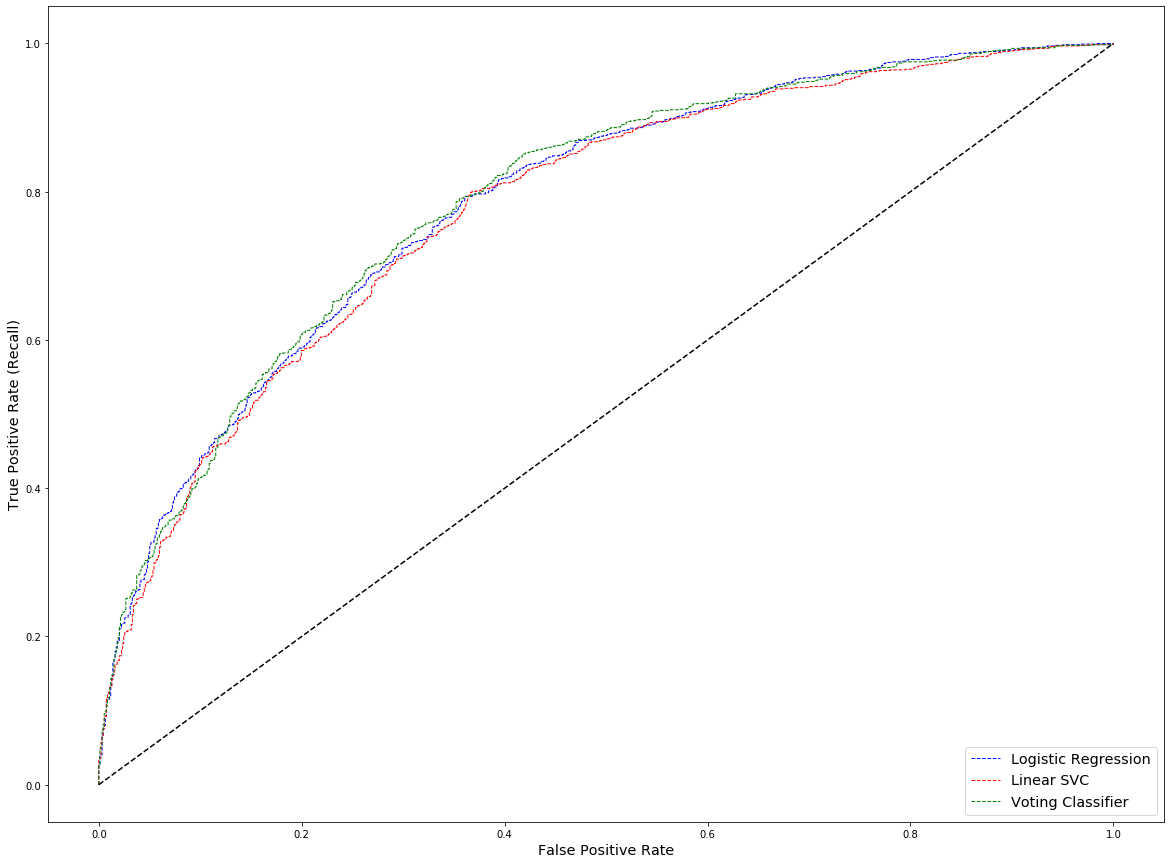

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

np.random.seed(42)

y_scores_win_log = cross_val_predict(log_grid.best_estimator_, X_train_win_prepared, 
                                 y_train_win, cv=5, method="predict_proba")[:,1]
y_scores_win_svc = cross_val_predict(lin_svc_grid.best_estimator_, X_train_win_prepared, 
                               y_train_win, cv=5, method="predict_proba")[:,1]
y_scores_win_vote = cross_val_predict(voting_grid_win.best_estimator_, X_train_win_prepared, 
                                 y_train_win, cv=5, method="predict_proba")[:,1]


fpr_win_log, tpr_win_log, thresh_win_log = roc_curve(y_train_win, y_scores_win_log)
fpr_win_svc, tpr_win_svc, thresh_win_svc = roc_curve(y_train_win, y_scores_win_svc)
fpr_win_vote, tpr_win_vote, thresh_win_vote = roc_curve(y_train_win, y_scores_win_vote)

plt.figure(figsize=(20,15))
plt.plot(fpr_win_log, tpr_win_log, "b--", linewidth=1, label="Logistic Regression")
plt.plot(fpr_win_svc, tpr_win_svc, "r--", linewidth=1, label="Linear SVC")
plt.plot(fpr_win_vote, tpr_win_vote, "g--", linewidth=1, label="Voting Classifier")
plt.xlabel("False Positive Rate", fontsize="x-large")
plt.ylabel("True Positive Rate (Recall)", fontsize="x-large")
plt.legend(loc="lower right", fontsize="x-large")
plt.plot([0,1], [0,1], "k--")

Looking more explicitly at the area under the ROC curve, the voting classifier does have the highest score, followed by logistic regression.

In [48]:
from sklearn.metrics import roc_auc_score

print("Logistic Regression:", roc_auc_score(y_train_win, y_scores_win_log))
print("Linear SVM:", roc_auc_score(y_train_win, y_scores_win_svc))
print("Voting:", roc_auc_score(y_train_win, y_scores_win_vote))

Logistic Regression: 0.786071378361196
Linear SVM: 0.7774468393637612
Voting: 0.789518010820905


A second way to view the quality of each model is to examine their classification reports, which contain the accuracy, precision, recall, and F1 scores. The voting classifier has a slightly higher accuracy. Additionally, the recall for cases where the away team wins is slightly higher than the other two models, and the same is true of the recall in cases where the home team wins. This leads to a higher overall average recall.

Because the voting classifier performs slightly better than the other two in both area under the ROC curve and the classification report, it was chosen as the final win prediction model.

In [49]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_log = (y_scores_win_log > 0.5).astype(int)
y_pred_svc = (y_scores_win_svc > 0.5).astype(int)
y_pred_vote = (y_scores_win_vote > 0.5).astype(int)

print("Logistic Regression:\n", classification_report(y_train_win, y_pred_log))
print("\n")
print("Linear SVC:\n", classification_report(y_train_win, y_pred_svc))
print("\n")
print("Voting Classifier:\n", classification_report(y_train_win, y_pred_vote))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       937
           1       0.74      0.78      0.76      1207

    accuracy                           0.72      2144
   macro avg       0.72      0.71      0.72      2144
weighted avg       0.72      0.72      0.72      2144



Linear SVC:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66       937
           1       0.74      0.78      0.76      1207

    accuracy                           0.72      2144
   macro avg       0.71      0.71      0.71      2144
weighted avg       0.72      0.72      0.72      2144



Voting Classifier:
               precision    recall  f1-score   support

           0       0.70      0.65      0.67       937
           1       0.74      0.79      0.76      1207

    accuracy                           0.73      2144
   macro avg       0.72      0.72      0.72      2144
weighted avg   

In [50]:
best_win_model = voting_grid_win.best_estimator_

The test set is prepared using the preparation pipeline. The game winner is then predicted for the test set. A classification report is generated for the prediction. The precision, recall, and F1 score are higher if the home team wins. The accuracy is similar to the accuracy determined using cross validation.

In [52]:
X_test_win_prepared = win_pipe.transform(X_test_win)
y_pred = best_win_model.predict(X_test_win_prepared)
print(classification_report(y_test_win, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       222
           1       0.77      0.81      0.79       314

    accuracy                           0.75       536
   macro avg       0.74      0.73      0.74       536
weighted avg       0.74      0.75      0.74       536



To determine how correct the model is given the prediction at differing confidence levels, a range of percentages was generated. For each percentage, the percent of instances that the model correctly identified given the prediction is shown. 

For example, for instances where the model had between 30% and 35% confidence that the away team would win, the model correctly predicted that the home team would win 76.0% of the time.

In [53]:
from sklearn.metrics import confusion_matrix

y_win_pred_proba = best_win_model.predict_proba(X_test_win_prepared)
confidence = {"Away Win Percentage": list(), 
              "Percent Correct": list()}
for perc in [0.05 * x for x in range(6, 16)]:
    y_pred = y_win_pred_proba[:, 1] > perc
    conf = confusion_matrix(y_test_win, y_pred)
    if perc < 0.5: perc_correct = conf[0,0] / (conf[0,0] + conf[1,0])
    else: perc_correct = conf[1,1] / (conf[1,1] + conf[0,1])
    confidence["Away Win Percentage"].append("{}%".format(int(perc * 100)))
    confidence["Percent Correct"].append("{}%".format(round(perc_correct * 100, 1)))
pd.DataFrame(confidence, index=range(len(confidence["Percent Correct"])))

,Away Win Percentage,Percent Correct
0,30%,81.2%
1,35%,76.0%
2,40%,76.0%
3,45%,73.3%
4,50%,77.1%
5,55%,80.1%
6,60%,81.0%
7,65%,83.6%
8,70%,85.8%
9,75%,88.5%


## Home Beats Spread Prediction

The last model entails predicting whether a home team will beat the betting spread. New data was required to determine this, as the **sportsreference** package does not provide spread data. This data was compiled in a Kaggle dataset, **NFL Scores and Betting Data**  (Tobycrabtree, 2020). The zip file was downloaded from Kaggle and unzipped to extract the historical spread. The dataset includes the date of the match up, in addition to the away and home team, spread for the favorite, and the favorite team ID.

In [54]:
import zipfile
import os

os.system("kaggle datasets download -d tobycrabtree/nfl-scores-and-betting-data")
with zipfile.ZipFile("nfl-scores-and-betting-data.zip", 'r') as zip_ref:
    zip_ref.extractall("nfl_odds_db")
historical_odds = pd.read_csv("nfl_odds_db/spreadspoke_scores.csv")
historical_odds.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,09/02/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,09/03/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,09/04/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,09/09/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,09/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


The team ID's were needed to convert the team names to usable team names for merging with the schedule dataframe. The head of this dataframe is shown below.

In [55]:
team_id = pd.read_csv("nfl_odds_db/nfl_teams.csv")
team_id.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central


The process for developing a dataset for evaluation was very similar to that for home spread. However, in addition to the dataframes for team statistics and team schedule by year, a dictionary containing the team name and corresponding dictionary, and one that matches team abbreviations from the **sportsreference** package and the spread dataframe were created. 

The away teams and home teams were then determined from the schedule dataframes. These team ID's and dates of the games were then matched with those from the spread dataframe and merged. The predicted home spread was then extracted from the spread column of the merged dataframe. The actual spread was also extracted based on the home and away score. A binary column was created that determined if the actual spread was greater than the predicted spread. This indicated whether the away team beat the spread. 

The stats dataframe was then merged with this dataframe to create the final dataframe by year. This process was completed for each year in the range.

In [56]:
stats_per_col = ["margin_of_victory",
                 "percent_drives_with_points", "percent_drives_with_turnovers", "pass_net_yards_per_attempt",
                 "rush_yards_per_attempt", "strength_of_schedule", "win_percentage",
                 "yards_per_play"]
stats_total = ["first_downs", "first_downs_from_penalties", "fumbles", "interceptions", 
                  "pass_attempts", "pass_completions", "pass_first_downs", "pass_touchdowns",
                  "pass_yards", "penalties", "plays", "points_contributed_by_offense",
                  "points_difference", "rush_attempts", "rush_first_downs", "rush_touchdowns", 
                  "rush_yards", "turnovers", "yards", "yards_from_penalties"]

year1 = 2010
year2 = 2019

all_year_df_spread = pd.DataFrame()

for year in range(year1, year2 + 1):
    stats_df = pd.DataFrame()
    games_df = pd.DataFrame()
    abbr_dict = dict()
    abbr_map = dict()
    teams = Teams(year)
    for team in teams:
        stats_df = pd.concat([stats_df, team.dataframe], axis=0)
        team_abbrev = team.abbreviation
        team_sched = Schedule(abbreviation=team_abbrev, year=year)
        abbr_dict[team.abbreviation] = team.name
        abbr_map[team.abbreviation] = team_id[team_id["team_id_pfr"] == 
                                              team.abbreviation]["team_id"].iloc[0]
        team_sched_df = team_sched.dataframe
        try:
            team_sched_df["team"] = team_abbrev
        except TypeError:
            continue
        games_df = pd.concat([games_df, team_sched_df], axis=0)
    games_df = games_df[["boxscore_index", "team", "opponent_abbr", "location", "points_allowed", 
                         "points_scored", "datetime"]].copy()
    games_df["home"] = games_df.apply(lambda x: x["team"] if x["location"] == "Home" 
                                      else x["opponent_abbr"], axis=1)
    games_df["away"] = games_df.apply(lambda x: x["team"] if x["location"] == "Away" 
                                      else x["opponent_abbr"], axis=1)
    games_df["schedule_date"] = games_df["boxscore_index"].apply(lambda x: x[4:6] + "/" + x[6:8] + "/" + x[:4])
    games_df["team_home"] = games_df["home"].apply(lambda x: abbr_dict[x])
    games_df = pd.merge(games_df, historical_odds, how="left", on=("team_home", "schedule_date"))
    games_df = games_df[games_df["team_favorite_id"].isin(abbr_map.values())]
    games_df["team_favorite_id"] = games_df["team_favorite_id"].\
        apply(lambda x: [k for k,v in abbr_map.items() if v == x][0])
    games_df["home_id"] = games_df["boxscore_index"].apply(lambda x: x[-3:].upper())
    games_df["home_spread"] = games_df.apply(lambda x: x["spread_favorite"] 
                        if x["team_favorite_id"] == x["home_id"] else -x["spread_favorite"], axis=1)
    games_df["actual_spread"] = games_df.apply(lambda x: x["points_allowed"] - x["points_scored"] 
                                         if x["team_home"] != abbr_dict[x["opponent_abbr"]] else 
                                        x["points_scored"] - x["points_allowed"], axis=1)
    games_df["away_beat_spread"] = (games_df["actual_spread"] > games_df["home_spread"]).astype(int)
    games_df = games_df[["home", "away", "away_beat_spread", "home_spread"]].copy()
    games_df.drop_duplicates(inplace=True)
    games_df = games_df.reset_index().drop("index", axis=1)
    
    stats_df[stats_total] = stats_df[stats_total].div(stats_df["games_played"], axis=0)
    
    chosen_col = stats_per_col + stats_total + ["abbreviation"]
    stats_df = stats_df[chosen_col]
    
    home_df = pd.merge(games_df, stats_df, left_on="home", right_on="abbreviation")
    full_df = pd.merge(home_df, stats_df, left_on="away", right_on="abbreviation", 
                       suffixes=("_home", "_away"))
    full_df.drop(["home", "away", "abbreviation_home", "abbreviation_away"], 
                 axis=1, inplace=True)
    
    all_year_df_spread = pd.concat([all_year_df_spread, full_df], axis=0)

The resulting dataframe had the prediction of whether the away team will beat the spread, home spread, and the same factors as in the spread prediction analysis.

In [57]:
all_year_df_spread.head()

,away_beat_spread,home_spread,margin_of_victory_home,percent_drives_with_points_home,percent_drives_with_turnovers_home,pass_net_yards_per_attempt_home,rush_yards_per_attempt_home,strength_of_schedule_home,win_percentage_home,yards_per_play_home,...,plays_away,points_contributed_by_offense_away,points_difference_away,rush_attempts_away,rush_first_downs_away,rush_touchdowns_away,rush_yards_away,turnovers_away,yards_away,yards_from_penalties_away
0,0,-5.5,12.8,47.0,5.4,7.2,4.3,2.6,0.875,5.9,...,65.375,-9.28625,-4.5625,26.75,5.3125,0.5,95.125,2.125,330.5625,45.3125
1,0,-9.5,3.9,32.2,10.6,5.9,4.4,2.5,0.688,5.2,...,65.375,-9.28625,-4.5625,26.75,5.3125,0.5,95.125,2.125,330.5625,45.3125
2,0,2.5,-3.8,27.7,15.8,5.8,4.0,2.3,0.313,5.0,...,65.375,-9.28625,-4.5625,26.75,5.3125,0.5,95.125,2.125,330.5625,45.3125
3,0,-8.0,8.9,36.9,9.5,6.9,4.1,1.3,0.750,5.6,...,65.375,-9.28625,-4.5625,26.75,5.3125,0.5,95.125,2.125,330.5625,45.3125
4,1,-7.0,2.9,40.2,13.4,6.6,3.8,-0.1,0.625,5.6,...,65.375,-9.28625,-4.5625,26.75,5.3125,0.5,95.125,2.125,330.5625,45.3125


Next, the dataframe was separated into X and y dataframes. These dataframes were separated into training and test data.

In [58]:
np.random.seed(42)

X_spread = all_year_df_spread.iloc[:,1:]
y_spread = all_year_df_spread.iloc[:,0]

X_train_spread, X_test_spread, y_train_spread, y_test_spread = \
    train_test_split(X_spread, y_spread, test_size=0.2, random_state=42)

The pipeline for processing the data was the same as with prior analyses. The train data was transformed using this pipeline.

In [59]:
spread_pipe = Pipeline([
    ("add_feat", AddedFeatures()),
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

spread_pipe.fit(X_train_spread)
X_train_spread_prepared = spread_pipe.transform(X_train_spread)

The first model tested was the logistic regression model. The accuracy for this model was substantially lower than that for the best model predicting whether the home team won. This was expected as the betting lines were created to best model the results, qualifying the size of the predicted winner's spread.

In [60]:
np.random.seed(42)

log_reg = LogisticRegression()
log_reg.fit(X_train_spread_prepared, y_train_spread)
np.mean(cross_val_score(log_reg, X_train_spread_prepared, y_train_spread, cv=3, scoring="accuracy"))

0.6264640386556816

The logistic regression model was then analyzed with differing hyperparameters using a grid search with cross validation. The grid search was then fitted to the training data.

In [61]:
np.random.seed(42)

log_reg = LogisticRegression()

log_params = [{"C":[10**x for x in range(-3, 4)]}]

log_grid = GridSearchCV(log_reg, log_params, cv=5, scoring="accuracy")
log_grid.fit(X_train_spread_prepared, y_train_spread)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

The average cross validation score for the best estimator was substantially higher than that with default parameters.

In [62]:
log_grid.best_score_

0.6311822892133773

The parameters were then fine-tuned further using cross validation. The ideal hyperparameter was found from the prior grid search, and the new parameters were based around this hyperparameter.

In [63]:
log_grid.best_params_

{'C': 10}

Using grid search, the parameters were updated for further fine-tuning. The grid search was fitted to the training data.

In [64]:
np.random.seed(42)

log_reg = LogisticRegression()
log_updated_params = [{"C": range(5, 35, 5)}]
log_updated_grid = GridSearchCV(log_reg, log_updated_params, cv=5, scoring="accuracy")
log_updated_grid.fit(X_train_spread_prepared, y_train_spread)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid=[{'C': range(5, 35, 5)}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

The best score for the logistic regression grid was the same as for the model prior to fine-tuning the parameters.

In [65]:
log_updated_grid.best_score_

0.6311822892133773

In [66]:
best_log_reg = log_updated_grid.best_estimator_

Next, a linear SVM was used to model the data. The mean cross validation score was slightly lower than that for the default logistic regression model.

In [67]:
from sklearn.svm import LinearSVC

np.random.seed(42)

lin_svm = LinearSVC()
np.mean(cross_val_score(lin_svm, X_train_spread_prepared, y_train_spread, cv=5, scoring="accuracy"))

0.6302264150943396

Next, the linear SVM model was evaluated using various values of the "C" hyperparameter. The main SVM function was used to enable probability prediction. This grid was fitted to the training data.

In [68]:
np.random.seed(42)

lin_svm = SVC(max_iter=100000, kernel="linear", probability=True)
lin_svm_params = [{"C": [10**x for x in range(-3, 4)]}]
lin_svm_grid = GridSearchCV(lin_svm, lin_svm_params, cv=5, scoring="accuracy")
lin_svm_grid.fit(X_train_spread_prepared, y_train_spread)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=100000, probability=True, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

The best score for the cross validated linear SVM model is lower than that for the cross validated logistic regression.

In [69]:
lin_svm_grid.best_score_

0.6241168158266603

The best parameters were then used as a basis for further fine-tuning the model.

In [70]:
lin_svm_grid.best_params_

{'C': 0.1}

The updated parameters were used as a basis for a cross validated grid search. This grid was fitted to the training data.

In [71]:
np.random.seed(42)

lin_svm = SVC(max_iter=100000, kernel="linear", probability=True)
lin_svm_updated_params = [{"C": [0.05*x for x in range(1, 9)]}]
lin_svm_updated_grid = GridSearchCV(lin_svm, lin_svm_updated_params, cv=5, scoring="accuracy")
lin_svm_updated_grid.fit(X_train_spread_prepared, y_train_spread)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=100000, probability=True, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25,
                                0.30000000000000004, 0.35000000000000003,
                                0.4]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

The score for the updated linear SVM grid is higher than the prior model.

In [72]:
lin_svm_updated_grid.best_score_

0.6274140367404616

The random forest classifier was next used to model the data. The classifier with default hyperparamters was evaluated using cross validation with five folds. The score was much lower than that for either the logistic regression model or the linear SVM model. Thus, this model was not used for evaluation.

In [73]:
np.random.seed(42)

rfor_clf = RandomForestClassifier()
np.mean(cross_val_score(rfor_clf, X_train_spread_prepared, y_train_spread, cv=5))

0.5044739178690344

The extreme gradient boosting model was also evaluated using cross validation. The score is also substantially lower that for the logistic regression model and the linear SVM model, but is higher than that for the random forest classifier. However, this model will not be considered.

In [74]:
np.random.seed(42)

xgb_clf = XGBClassifier()
np.mean(cross_val_score(xgb_clf, X_train_spread_prepared, y_train_spread, cv=5))

0.5784173140954495

Given that the linear SVM and the logistic models were the most accurate, these models were combined into a voting classifier using soft voting. The same initial parameters were evaluated for both models, and the model was evaluated using grid search and cross validation. This grid was fitted to the training data.

In [75]:
np.random.seed(42)

lin_svc = SVC(max_iter=100000, kernel="linear", probability=True)
log_reg = LogisticRegression()

voting_clf = VotingClassifier(
    estimators=[("lin_svc", lin_svc), ("log_reg", log_reg)],
    voting="soft")

voting_params = [{"lin_svc__C": [10**x for x in range(-3, 4)],
                  "log_reg__C": [10**x for x in range(-3, 4)]}]

voting_spread_grid = GridSearchCV(voting_clf, voting_params, cv=5, scoring="accuracy")
voting_spread_grid.fit(X_train_spread_prepared, y_train_spread)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('lin_svc',
                                                     SVC(C=1.0, cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='auto_deprecated',
                                                         kernel='linear',
                                                         max_iter=100000,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
                                                   

The voting classifier was then further fine-tuned based on the best parameters. The best parameters from this analysis are shown below.

In [76]:
voting_spread_grid.best_params_

{'lin_svc__C': 0.01, 'log_reg__C': 10}

The best score of this model is higher than any other model.

In [77]:
voting_spread_grid.best_score_

0.6335374470089497

The voting classifier was adjusted with updated parameters. The model was updated using a cross validated grid search.

In [78]:
np.random.seed(42)

lin_svc = SVC(max_iter=100000, kernel="linear", probability=True)
log_reg = LogisticRegression()

voting_clf = VotingClassifier(
    estimators=[("lin_svc", lin_svc), ("log_reg", log_reg)],
    voting="soft")

voting_updated_params = [{"lin_svc__C": [0.005*x for x in range(1, 7)],
                  "log_reg__C": [5*x for x in range(1, 7)]}]

voting_spread_updated_grid = GridSearchCV(voting_clf, voting_updated_params, cv=5, scoring="accuracy")
voting_spread_updated_grid.fit(X_train_spread_prepared, y_train_spread)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('lin_svc',
                                                     SVC(C=1.0, cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='auto_deprecated',
                                                         kernel='linear',
                                                         max_iter=100000,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
                                                   

The best score for the voting classifier was higher than that for any other model. Thus, this model was be chosen as the final model.

In [79]:
voting_spread_updated_grid.best_score_

0.6344795101271785

In a similar fashion as was completed for predicting wins, an ROC curve was created for the top three models for predicting whether a team would beat the spread. In this case, there is no clear preferable model, as all models are fairly close in the plot.

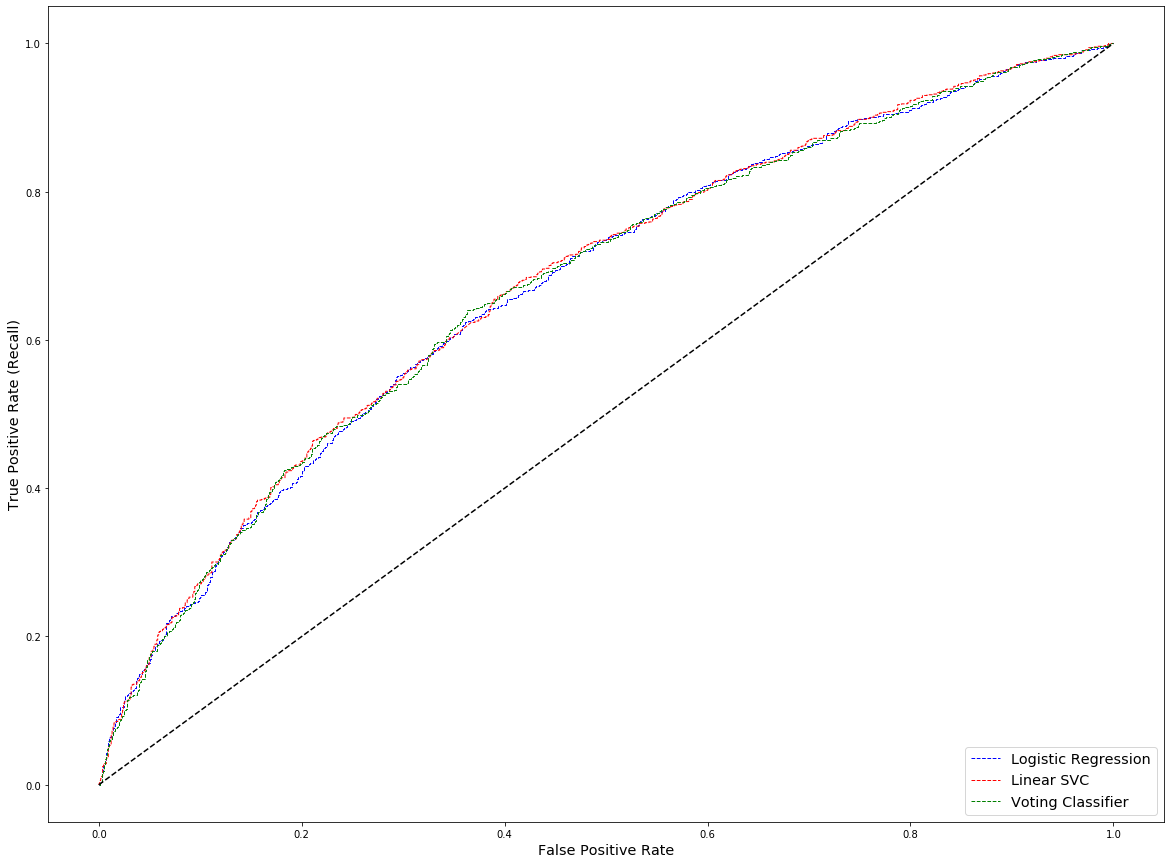

In [80]:
np.random.seed(42)

y_scores_spread_log = cross_val_predict(log_updated_grid.best_estimator_, X_train_spread_prepared, 
                                 y_train_spread, cv=5, method="predict_proba")[:,1]
y_scores_spread_svc = cross_val_predict(lin_svm_updated_grid.best_estimator_, X_train_spread_prepared, 
                               y_train_spread, cv=5, method="predict_proba")[:,1]
y_scores_spread_vote = cross_val_predict(voting_spread_updated_grid.best_estimator_, X_train_spread_prepared, 
                                 y_train_spread, cv=5, method="predict_proba")[:,1]


fpr_spread_log, tpr_spread_log, thresh_spread_log = roc_curve(y_train_spread, y_scores_spread_log)
fpr_spread_svc, tpr_spread_svc, thresh_spread_svc = roc_curve(y_train_spread, y_scores_spread_svc)
fpr_spread_vote, tpr_spread_vote, thresh_spread_vote = roc_curve(y_train_spread, y_scores_spread_vote)

plt.figure(figsize=(20,15))
plt.plot(fpr_spread_log, tpr_spread_log, "b--", linewidth=1, label="Logistic Regression")
plt.plot(fpr_spread_svc, tpr_spread_svc, "r--", linewidth=1, label="Linear SVC")
plt.plot(fpr_spread_vote, tpr_spread_vote, "g--", linewidth=1, label="Voting Classifier")
plt.xlabel("False Positive Rate", fontsize="x-large")
plt.ylabel("True Positive Rate (Recall)", fontsize="x-large")
plt.legend(loc="lower right", fontsize="x-large")
plt.plot([0,1], [0,1], "k--")

However, looking at the area under the ROC curve, the linear SVM model performs the best, followed by the voting classifier.

In [81]:
from sklearn.metrics import roc_auc_score

print("Logistic Regression:", roc_auc_score(y_train_spread, y_scores_spread_log))
print("Linear SVM:", roc_auc_score(y_train_spread, y_scores_spread_svc))
print("Voting:", roc_auc_score(y_train_spread, y_scores_spread_vote))

Logistic Regression: 0.6719988639792677
Linear SVM: 0.6753825194809805
Voting: 0.6729440687292543


When looking at the classification reports for the three top models, all three are very similar. However, the voting classifier has a higher recall than the logistic regression model for cases where the home team beat the spread, and has a higher precision than the linear SVM model. Additionally, the F1 score is higher for the voting classifier than that for the linear SVM in cases where the away team beat the spread. 

However, as previously shown, the area under the ROC curve is largest for the linear SVM model. Because the gap between the linear SVM model and the other models based on their areas under the ROC curve is sizable, and the accuracy of all models is roughly the same, the linear SVM model was chosen as the best model to predict beating the spread.

In [82]:
y_pred_spread_log = (y_scores_spread_log > 0.5).astype(int)
y_pred_spread_svc = (y_scores_spread_svc > 0.5).astype(int)
y_pred_spread_vote = (y_scores_spread_vote > 0.5).astype(int)

print("Logistic Regression:\n", classification_report(y_train_spread, y_pred_spread_log))
print("\n")
print("Linear SVM:\n", classification_report(y_train_spread, y_pred_spread_svc))
print("\n")
print("Voting Classifier:\n", classification_report(y_train_spread, y_pred_spread_vote))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.63      0.64      0.64      1068
           1       0.63      0.62      0.63      1055

    accuracy                           0.63      2123
   macro avg       0.63      0.63      0.63      2123
weighted avg       0.63      0.63      0.63      2123



Linear SVM:
               precision    recall  f1-score   support

           0       0.62      0.65      0.64      1068
           1       0.63      0.60      0.62      1055

    accuracy                           0.63      2123
   macro avg       0.63      0.63      0.63      2123
weighted avg       0.63      0.63      0.63      2123



Voting Classifier:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      1068
           1       0.63      0.62      0.63      1055

    accuracy                           0.63      2123
   macro avg       0.63      0.63      0.63      2123
weighted avg   

The best model is chosen as the best estimator from the voting classifier.

In [83]:
best_spread_model = lin_svm_updated_grid.best_estimator_

The test data was transformed using the data processing pipeline.

In [85]:
X_test_spread_prepared = spread_pipe.transform(X_test_spread)

The test data was evaluated using the chosen model. A classification report was created. The accuracy was similar to the accuracy found through cross validation. Additionally, the recall and precision were very similar for both classes.

In [86]:
y_pred = best_spread_model.predict(X_test_spread_prepared)
print(classification_report(y_test_spread, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       270
           1       0.65      0.60      0.62       261

    accuracy                           0.64       531
   macro avg       0.64      0.64      0.64       531
weighted avg       0.64      0.64      0.64       531



Using the same process as with win prediction, the percentages of the instances that were correctly classified given the confidence of their prediction were determined. These values were evaluated for confidence levels of the away team beating the spread. 

For example, in cases where the model was between 10% and 15% confident that the away team beat the spread, the model correctly classified instances where the home team beat the spread 66.7% of the time.

In [87]:
y_spread_pred_proba = best_spread_model.predict_proba(X_test_spread_prepared)
confidence = {"Away Beat Spread Percentage": list(), 
              "Percent Correct": list()}
for perc in [0.05 * x for x in range(2, 19)]:
    y_pred = y_spread_pred_proba[:, 1] > perc
    conf = confusion_matrix(y_test_spread, y_pred)
    if perc < 0.5: perc_correct = conf[0,0] / (conf[0,0] + conf[1,0])
    else: perc_correct = conf[1,1] / (conf[1,1] + conf[0,1])
    confidence["Away Beat Spread Percentage"].append("{}%".format(int(perc * 100)))
    confidence["Percent Correct"].append("{}%".format(round(perc_correct * 100, 1)))
pd.DataFrame(confidence, index=range(len(confidence["Percent Correct"])))

,Away Beat Spread Percentage,Percent Correct
0,10%,50.0%
1,15%,66.7%
2,20%,68.8%
3,25%,77.1%
4,30%,78.7%
5,35%,78.1%
6,40%,72.3%
7,45%,68.6%
8,50%,64.7%
9,55%,67.2%


## Final Prediction Function

This function uses the models to predict one of four metrics, spread of game, whether the home team wins, and whether the away team beats the spread. The function takes the prediction year to be used as a basis for team stats, the games to be predicted, the model used for prediction, and the model type, one of the following: "reg" for spread prediction, "win" for prediction of winning team, and "spread" for prediction of whether the away team will beat the spread.

Additionally, the function will take team names either in abbreviated or full format. As many team names or team abbreviations as desired can be entered. The home and away team do not have to both be of the same format in each game. This is accomplished by creating a dictionary that contains the names of each team in the given year and the corresponding abbreviation.

The function loops through each game and first delineates the away team and the home team. The team stats for each team are found using the stats for that year. A home team and an away team dataframe are created. The stats that are based on the full season are divided by the number of games played. The two dataframes are then concatenated and only the relevant columns are kept. All null values are replaced with 0, as unentered values are assumed to indicate that the team does not have any stats in this category.

The reported prediction depends on the type of model used. For the "reg" model, the predicted value is reported as a rounded predicted spread. These are added to a dictionary. If the model predicts whether the home team wins, the predictions are reported as probabilities of each outcome. If the model predicts whether the away team will beat the spread, the third component of the game input, the spread, is added to the beginning of the stats. The predictions are then reported based on the probabilities in each category.

In [88]:
def predict_outcome(year, games, model, model_type="reg"):
    """
    Predicts outcome for NFL games based on type of model. Takes in list of tuples or lists for games 
    parameter, with tuples of format (away team, home team, home spread).
    """   
    if any(len(game[0]) > 3 or len(game[1]) > 3 for game in games):
        teams = Teams(year=year)
        team_names = dict()
        for team in teams:     
            team_names[team.name] = team.abbreviation
    all_results = pd.DataFrame()
    for game in games:
        if len(game[1]) > 3:
            home_team = team_names[game[1]]
        else:
            home_team = game[1]
        if len(game[0]) > 3:
            away_team = team_names[game[0]]
        else:
            away_team = game[0]
        teams = Teams(year=year)
        home_df = teams(home_team).dataframe
        home_name = home_df["name"]
        home_df[stats_total] = home_df[stats_total].\
            div(home_df["wins"] + home_df["losses"], axis=0)
        home_df = home_df[chosen_col]
        away_df = teams(away_team).dataframe
        away_name = away_df["name"]
        away_df[stats_total] = away_df[stats_total].\
            div(away_df["wins"] + away_df["losses"], axis=0)
        away_df = away_df[chosen_col]
        home_df.columns = home_df.columns + "_home"
        away_df.columns = away_df.columns + "_away"
        full_series = pd.concat([home_df.iloc[0], away_df.iloc[0]])
        full_series.drop(["abbreviation_home", "abbreviation_away"], inplace=True)
        full_df = full_series.to_frame().T
        full_df.fillna(0, inplace=True)
        if model_type == "reg":
            full_df_prepared = nfl_pipe.transform(full_df)
            
            mod_metric = model.predict(full_df_prepared)
            full_results = {"Away Team": away_name.iloc[0], 
                        "Home Team": home_name.iloc[0],
                        "Home Spread": round(mod_metric[0], 1)}
        elif model_type == "win":
            full_df_prepared = win_pipe.transform(full_df)
            prob = model.predict_proba(full_df_prepared)
            home_prob = prob[0][1]
            away_prob = prob[0][0]
            full_results = {"Away Team": away_name.iloc[0], 
                        "Home Team": home_name.iloc[0],
                        "Away Probability": "{}%".format(round(away_prob * 100, 1)),
                        "Home Probability": "{}%".format(round(home_prob * 100, 1))}
        elif model_type == "spread":
            spread = game[2]
            full_df["home_spread"] = spread
            cols = full_df.columns.tolist()
            new_cols = [cols[-1]] + cols[:-1]
            full_df = full_df[new_cols]
            full_df_prepared = spread_pipe.transform(full_df)
            
            prob = model.predict_proba(full_df_prepared)
            away_spread = prob[0][1]
            home_spread = prob[0][0]
            full_results = {"Away Team": away_name.iloc[0], 
                        "Home Team": home_name.iloc[0],
                        "Away Team Beat Spread": "{}%".format(round(away_spread * 100, 1)),
                        "Home Team Beat Spread": "{}%".format(round(home_spread * 100, 1))}
        full_results_df = pd.DataFrame(full_results, index=[0])
        all_results = pd.concat([all_results, full_results_df], axis=0)
    all_results = all_results.reset_index().drop("index", axis=1)
    return all_results

The abbreviations for each team are shown for the given year as optional inputs into the model.

In [89]:
year = 2020
teams = Teams(year=year)
team_abbrev = list()
team_names = list()
for team in teams: 
    team_abbrev.append(team.abbreviation)
    team_names.append(team.name)
team_names_df = pd.DataFrame({"Name": team_names, "Abbreviation": team_abbrev})
team_names_df = team_names_df.sort_values(by="Name").set_index("Name")
team_names_df

,Abbreviation
Name,
Arizona Cardinals,CRD
Atlanta Falcons,ATL
Baltimore Ravens,RAV
Buffalo Bills,BUF
Carolina Panthers,CAR
Chicago Bears,CHI
Cincinnati Bengals,CIN
Cleveland Browns,CLE
Dallas Cowboys,DAL


This is an example of how to use the function to predict home spread. The games shown here are those for the week 3 of the 2020 season.

In [90]:
predict_outcome(2020, [("MIA", "JAX", -3), ("CHI", "ATL", -3),
                       ("RAM", "BUF", -2), ("WAS", "CLE", -7),
                       ("OTI", "MIN", 2.5), ("RAI", "NWE", -5.5),
                       ("SFO", "NYG", -4), ("CIN", "PHI", -5),
                       ("HTX", "PIT", -4), ("NYJ", "CLT", -10.5),
                       ("CAR", "SDG", -6.5), ("TAM", "DEN", 6),
                       ("DET", "CRD", -5.5), ("DAL", "SEA", -5),
                       ("GNB", "NOR", -3.5), ("KAN", "RAV", -3.5)],
               best_reg_model, model_type="reg")

,Away Team,Home Team,Home Spread
0,Miami Dolphins,Jacksonville Jaguars,10.7
1,Chicago Bears,Atlanta Falcons,-18.1
2,Los Angeles Rams,Buffalo Bills,0.5
3,Washington Football Team,Cleveland Browns,9.1
4,Tennessee Titans,Minnesota Vikings,9.3
5,Las Vegas Raiders,New England Patriots,-6.7
6,San Francisco 49ers,New York Giants,24.0
7,Cincinnati Bengals,Philadelphia Eagles,-3.2
8,Houston Texans,Pittsburgh Steelers,-2.3
9,New York Jets,Indianapolis Colts,-1.4


This is the output for win prediction for week 3 of the 2020 NFL season.

In [91]:
predict_outcome(2020, [("MIA", "JAX", -3), ("CHI", "ATL", -3),
                       ("RAM", "BUF", -2), ("WAS", "CLE", -7),
                       ("OTI", "MIN", 2.5), ("RAI", "NWE", -5.5),
                       ("SFO", "NYG", -4), ("CIN", "PHI", -5),
                       ("HTX", "PIT", -4), ("NYJ", "CLT", -10.5),
                       ("CAR", "SDG", -6.5), ("TAM", "DEN", 6),
                       ("DET", "CRD", -5.5), ("DAL", "SEA", -5),
                       ("GNB", "NOR", -3.5), ("KAN", "RAV", -3.5)],
               best_win_model, model_type="win")

,Away Team,Home Team,Away Probability,Home Probability
0,Miami Dolphins,Jacksonville Jaguars,72.8%,27.2%
1,Chicago Bears,Atlanta Falcons,29.8%,70.2%
2,Los Angeles Rams,Buffalo Bills,57.0%,43.0%
3,Washington Football Team,Cleveland Browns,70.3%,29.7%
4,Tennessee Titans,Minnesota Vikings,94.7%,5.3%
5,Las Vegas Raiders,New England Patriots,47.5%,52.5%
6,San Francisco 49ers,New York Giants,94.0%,6.0%
7,Cincinnati Bengals,Philadelphia Eagles,29.7%,70.3%
8,Houston Texans,Pittsburgh Steelers,30.9%,69.1%
9,New York Jets,Indianapolis Colts,47.0%,53.0%


This is the output for predicting which team will beat the spread week 3 of the 2020 NFL season.

In [92]:
predict_outcome(2020, [("MIA", "JAX", -2.5), ("CHI", "ATL", -2.5),
                       ("RAM", "BUF", -1.5), ("WAS", "CLE", -7),
                       ("OTI", "MIN", 2.5), ("RAI", "NWE", -7),
                       ("SFO", "NYG", 3), ("CIN", "PHI", -6),
                       ("HTX", "PIT", -3.5), ("NYJ", "CLT", -12),
                       ("CAR", "SDG", -6.5), ("TAM", "DEN", 5.5),
                       ("DET", "CRD", -5), ("DAL", "SEA", -5),
                       ("GNB", "NOR", -3.5), ("KAN", "RAV", -3.5)],
               best_spread_model, model_type="spread")

,Away Team,Home Team,Away Team Beat Spread,Home Team Beat Spread
0,Miami Dolphins,Jacksonville Jaguars,88.3%,11.7%
1,Chicago Bears,Atlanta Falcons,3.0%,97.0%
2,Los Angeles Rams,Buffalo Bills,50.0%,50.0%
3,Washington Football Team,Cleveland Browns,91.3%,8.7%
4,Tennessee Titans,Minnesota Vikings,72.5%,27.5%
5,Las Vegas Raiders,New England Patriots,36.8%,63.2%
6,San Francisco 49ers,New York Giants,95.0%,5.0%
7,Cincinnati Bengals,Philadelphia Eagles,36.4%,63.6%
8,Houston Texans,Pittsburgh Steelers,80.2%,19.8%
9,New York Jets,Indianapolis Colts,92.8%,7.2%


The joblib fuction was used to dump the models and variables necessary to run the models in a separate notebook.

In [95]:
from joblib import dump

dump(best_reg_model, "best_reg_model.joblib")
dump(best_win_model, "best_win_model.joblib")
dump(best_spread_model, "best_spread_model.joblib")
dump(stats_total, "stats_total.joblib")
dump(stats_per_col,  "stats_per_col.joblib")
dump(nfl_pipe, "nfl_pipe.joblib")
dump(win_pipe, "win_pipe.joblib")
dump(spread_pipe, "spread_pipe.joblib")

['spread_pipe.joblib']

# Conclusion

Given the aforementioned challenge in beating the spread, the success of the model to predict whether the home team will beat the spread is quite surprising. This model achieved 64% accuracy on the testing data. Additionally, the model predicting wins performed well, with 75% accuracy in predicting on the testing data. The model predicting the spread did somewhat well, with an RMSE of less than 12 points. Given the low scores in the NFL, this model's performance was not as impressive. The most effective models chosen were a lasso regression model to predict spread, a voting classifier using logistic regression and linear SVM to predict wins, and a linear SVM model to beat the spread. 

While these models performed well, a limitation in this methodology is the inclusion of year-end statistics in the training and test data. While the statistics were averaged to reporting per game, the statistics at the end of the year are often more representative of the quality of the team. A separate methodology was tested previously that looked at statistics for the previous five games based on box score results, which occasionally spanned two seasons. However, models using this data did not perform as well, and the time needed to generate data was deemed too long for inclusion in this notebook. Given this limitation, the model should perform better later in the season, as more games have been played and the statistics are closer to their year-end averages.

The models will be consistently tracked for their performance in the 2020 season. The performance will be available in a separate spreadsheet book. Year-end accuracy and performance measures will be provided at the end of the season.

# References

Tobycrabtree. (2020). NFL scores and betting data. Retrieved from Kaggle.com: https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data